## Predicting Text Sentiment Using Natural Language Processing

### Load the dataset into memory.

In [3]:
import pandas as pd
import numpy as np
import re
import string
import spacy
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

from spacy.lang.en import English
from spacy.lang.en.stop_words import STOP_WORDS

from sklearn import svm
from sklearn import preprocessing
from sklearn.base import TransformerMixin
from sklearn.tree import DecisionTreeClassifier
from sklearn.base import BaseEstimator
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import classification_report
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import SGDClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer

from time import time
from pprint import pprint


sentiment = pd.read_csv('C:\\Users\\dusti\\Documents\\Maryville\\Text Mining\\sentiment140.csv', encoding='latin1', header=None)
sentiment.head(5)

,0,1,2,3,4,5
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


### Clean and preprocess the texts.

In [2]:
#reduce down to only the polarity and the text of the tweet
sentiment = sentiment[[0,5]]
sentiment = sentiment.rename(columns = {0:'polarity', 5:'text'}, inplace=False)

sentiment.head(5)

,polarity,text
0,0,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,is upset that he can't update his Facebook by ...
2,0,@Kenichan I dived many times for the ball. Man...
3,0,my whole body feels itchy and like its on fire
4,0,"@nationwideclass no, it's not behaving at all...."


In [3]:
#check for missing data
percent_missing = sentiment.isnull().sum() * 100 / len(sentiment)
percent_missing

polarity    0.0
text        0.0
dtype: float64

In [4]:
#check the percentage of the sentiment
sentiment['polarity'].value_counts(normalize= True)

0    0.5
4    0.5
Name: polarity, dtype: float64

<AxesSubplot:>

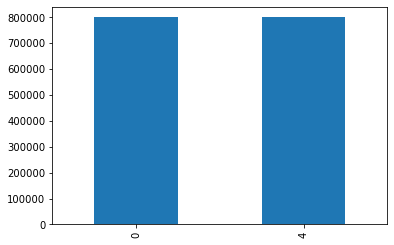

In [5]:
#build a graph showing the percentages of polarity
sentiment.polarity.value_counts().sort_values().plot(kind = 'bar')

In [6]:
nlp = spacy.load("en_core_web_sm")
stop_words = spacy.lang.en.stop_words.STOP_WORDS

#tokenizer function
def spacy_tokenizer(sentence):
    mytokens = nlp(sentence)
    mytokens = [word.lemma_ for word in mytokens if word not in stop_words] #remove stopwords
    return mytokens   

In [7]:
#transformer class generation
class features(TransformerMixin):
    def transform(self, X, **transform_params):
        return [clean_text(text) for text in X]
    
    def fit(self, X, y= None, **fit_params):
        return self
    
    def get_params(self, deep= True):
        return {}

#function to clean text
def clean_text(text):
    text = ' '.join(re.sub("(nan)|(@[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)"," ",text).split())
    return text.strip().lower() #remove leading/trailing spaces and convert to lowercase

In [8]:
le = preprocessing.LabelEncoder()

sentiment['polarity']=le.fit_transform(sentiment['polarity'])
sentiment['polarity'].value_counts(normalize=True)

0    0.5
1    0.5
Name: polarity, dtype: float64

In [9]:
X = sentiment['text']
y = sentiment['polarity']

#reduce the dataset for manageable times
X_newWhole, X_test, y_newWhole, y_test = train_test_split(X, y, stratify=y, test_size=0.999)
#split the dataset
X_train, X_test,y_train, y_test = train_test_split(X_newWhole, y_newWhole, stratify=y_newWhole, test_size=0.2)

print(f'X_train dimension: {X_train.shape}; y_train dimension: {y_train.shape}')
print(f'X_test dimension: {X_test.shape}; y_train dimension: {y_test.shape}')

sentiment['polarity'].value_counts(normalize=True) #check the distribution of the data after splitting

X_train dimension: (1280,); y_train dimension: (1280,)
X_test dimension: (320,); y_train dimension: (320,)


0    0.5
1    0.5
Name: polarity, dtype: float64

### Build the first model based on pipeline using the support vector machines.

In [10]:
t0 = time()

tfidf_vector = TfidfVectorizer(tokenizer = spacy_tokenizer, ngram_range = (1,1))

#SVM classifier
classifier = svm.SVC(kernel='linear', random_state=1)

#create pipeline
pipeline = Pipeline ([("cleaner", features()),
                 ("vectorizer", tfidf_vector),
                 ("classifier", classifier)])

#fit the model
pipeline.fit(X_train, y_train)

print(f"It takes about {time() - t0:.1f} seconds")

It takes about 10.8 seconds


### Check the first model.  Based on the precision, recall, and f1-score this model is fairly good.  Given this is a balanced dataset, the accuracy would be the best estimator.  At 72% it shows that this model performs adequately for the given problem.  In a more serious scenario (medical for instance) I would like to see a higher score.

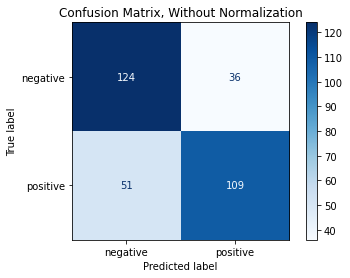

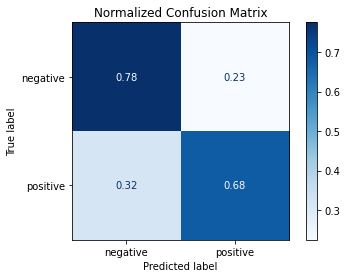

In [11]:
#change the target names from the encoding
target_names = ['negative', 'positive']

titles_options = [("Confusion Matrix, Without Normalization", None),
                  ("Normalized Confusion Matrix", 'true')]

for title, normalize in titles_options:
    disp = plot_confusion_matrix(pipeline, X_test, y_test,
                                 display_labels= target_names,
                                 cmap=plt.cm.Blues,
                                 normalize=normalize)
    disp.ax_.set_title(title)

plt.show()

In [12]:
#predictions
y_pred = pipeline.predict(X_test)

print(classification_report(y_test, y_pred, target_names = target_names))

              precision    recall  f1-score   support

    negative       0.71      0.78      0.74       160
    positive       0.75      0.68      0.71       160

    accuracy                           0.73       320
   macro avg       0.73      0.73      0.73       320
weighted avg       0.73      0.73      0.73       320



### Create the second model using pipeline, grid search CV for the hyperparameters for the estimators from Scikit Learn.

In [13]:
#new pipeline with tokenizer
pipeline = Pipeline ([("cleaner", features()),
                 ("vectorizer", TfidfVectorizer(tokenizer = spacy_tokenizer)),
                 ("classifier", classifier)])

parameters = {
    'vectorizer__max_df': (0.5, 1.0),
    'vectorizer__ngram_range': ((1, 1), (1,2)),
    'vectorizer__use_idf': (True, False),
}

#gridsearch
grid_search = GridSearchCV(pipeline, parameters, n_jobs=-1, verbose=1)

print("The pipeline contains:", [name for name, _ in pipeline.steps])
print()

print("parameters are as follows:")
pprint(parameters)
print()

grid_search.fit(X_train, y_train)
print()

print(f"It takes about {time() - t0:.1f} seconds.")
print()

print(f"Best score = {grid_search.best_score_:0.3f}")
print()

print("Best parameters set:")
best_parameters = grid_search.best_estimator_.get_params()
for param_name in sorted(parameters.keys()):
    print("\t%s: %r" % (param_name, best_parameters[param_name]))

The pipeline contains: ['cleaner', 'vectorizer', 'classifier']

parameters are as follows:
{'vectorizer__max_df': (0.5, 1.0),
 'vectorizer__ngram_range': ((1, 1), (1, 2)),
 'vectorizer__use_idf': (True, False)}

Fitting 5 folds for each of 8 candidates, totalling 40 fits

It takes about 225.4 seconds.

Best score = 0.680

Best parameters set:
	vectorizer__max_df: 1.0
	vectorizer__ngram_range: (1, 2)
	vectorizer__use_idf: True


### Tune the second model and perform model diagnostics. This model is no better than the first one given the 72% accuracy.  It took a lot more time, so I'd recommend sticking with the base model.

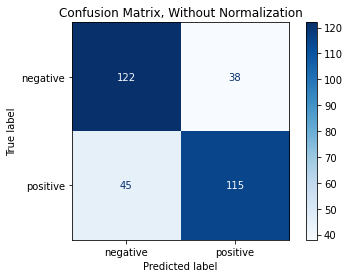

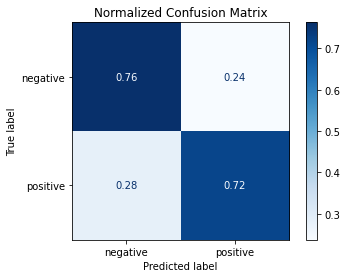

In [14]:
#change the target names from the encoding
target_names = ['negative', 'positive']

titles_options = [("Confusion Matrix, Without Normalization", None),
                  ("Normalized Confusion Matrix", 'true')]

#confusion matrix
for title, normalize in titles_options:
    disp = plot_confusion_matrix(grid_search, X_test, y_test,
                                 display_labels= target_names,
                                 cmap=plt.cm.Blues,
                                 normalize=normalize)
    disp.ax_.set_title(title)

plt.show()

In [15]:
#predictions with grid search
y_pred = grid_search.predict(X_test)

print(classification_report(y_test, y_pred, target_names = target_names))

              precision    recall  f1-score   support

    negative       0.73      0.76      0.75       160
    positive       0.75      0.72      0.73       160

    accuracy                           0.74       320
   macro avg       0.74      0.74      0.74       320
weighted avg       0.74      0.74      0.74       320



### Build the third model using pipeline, grid search CV, hyperparameter for the following classifiers:
+ Logistic regression
+ Support Vector Machine
+ Random Forest

In [16]:
#define estimator class for different classifiers
class ClfSwitcher(BaseEstimator):
    def __init__(
        self, 
        estimator = LogisticRegression(),
    ):

        self.estimator = estimator

    #fit the model
    def fit(self, X, y=None, **kwargs):
        self.estimator.fit(X, y)
        return self

    #predict the label
    def predict(self, X, y=None):
        return self.estimator.predict(X)

    #predict the probability
    def predict_proba(self, X):
        return self.estimator.predict_proba(X)

    #compute the score
    def score(self, X, y):
        return self.estimator.score(X, y)

In [17]:
#create the pipeline of cleaner, tfidf and classifier to be specified by ClfSwitcher
pipeline = Pipeline ([("cleaner", features()),
                 ("vectorizer", TfidfVectorizer()),
                 ("classifier", ClfSwitcher())])

parameters = [
    {
        'vectorizer__tokenizer': [spacy_tokenizer],
        'vectorizer__max_df': [1.0],
        'vectorizer__norm': ('l1', 'l2'),
        'vectorizer__stop_words': ['english', None],
        'classifier__estimator': [LogisticRegression(random_state=1)], 
        'classifier__estimator__penalty': ('l2', 'l1'),
        'classifier__estimator__fit_intercept': [True, False],
    },
    {
        'vectorizer__tokenizer': [spacy_tokenizer],
        'vectorizer__max_df': [1.0],
        'vectorizer__norm': ('l1', 'l2'),
        'vectorizer__stop_words': ['english', None],
        'classifier__estimator': [svm.SVC(random_state=1)],
        'classifier__estimator__kernel': ('linear', 'rbf'),
    },
    {
        'vectorizer__tokenizer': [spacy_tokenizer],
        'vectorizer__max_df': [1.0],
        'vectorizer__norm': ('l1', 'l2'),
        'vectorizer__stop_words': ['english', None],
        'classifier__estimator': [RandomForestClassifier(random_state=1)],
        'classifier__estimator__n_estimators': [100, 500],
        'classifier__estimator__criterion': ('gini', 'entropy'),
    },
]

print("The pipeline contains:", [name for name, _ in pipeline.steps])
print()

print("parameters are as follows:")
pprint(parameters)
print()

#gridsearch CV
gscv = GridSearchCV(pipeline, parameters, cv=5, n_jobs= -1, return_train_score=False, verbose=3)
gscv.fit(X_train, y_train)
print()

print(f"It takes about {time() - t0:.3f} seconds")

The pipeline contains: ['cleaner', 'vectorizer', 'classifier']

parameters are as follows:
[{'classifier__estimator': [LogisticRegression(random_state=1)],
  'classifier__estimator__fit_intercept': [True, False],
  'classifier__estimator__penalty': ('l2', 'l1'),
  'vectorizer__max_df': [1.0],
  'vectorizer__norm': ('l1', 'l2'),
  'vectorizer__stop_words': ['english', None],
  'vectorizer__tokenizer': [<function spacy_tokenizer at 0x000002660161AE50>]},
 {'classifier__estimator': [SVC(random_state=1)],
  'classifier__estimator__kernel': ('linear', 'rbf'),
  'vectorizer__max_df': [1.0],
  'vectorizer__norm': ('l1', 'l2'),
  'vectorizer__stop_words': ['english', None],
  'vectorizer__tokenizer': [<function spacy_tokenizer at 0x000002660161AE50>]},
 {'classifier__estimator': [RandomForestClassifier(random_state=1)],
  'classifier__estimator__criterion': ('gini', 'entropy'),
  'classifier__estimator__n_estimators': [100, 500],
  'vectorizer__max_df': [1.0],
  'vectorizer__norm': ('l1', 'l2'

### Tune the third model and perform model diagnostics. The best score on the final model search is a better than the last, but not a meaningful difference.

In [18]:
print(f"Best score= {gscv.best_score_:0.3f}")
print()

best_parameters = gscv.best_estimator_.get_params()

all_classifiers =[]
for parameter in parameters:
    all_classifiers.append(parameter['classifier__estimator'])
all_classifiers = [str(alg) for clf in all_classifiers for alg in clf]
print("All potential classifiers:")
pprint(all_classifiers)
print()

#location/index of the optimal classifier
idx = all_classifiers.index(str(best_parameters['classifier__estimator']))

print("Best parameters set:")
for param_name in sorted(parameters[idx].keys()):
    print("\t%s: %r" % (param_name, best_parameters[param_name]))

Best score= 0.682

All potential classifiers:
['LogisticRegression(random_state=1)',
 'SVC(random_state=1)',
 'RandomForestClassifier(random_state=1)']

Best parameters set:
	classifier__estimator: SVC(random_state=1)
	classifier__estimator__kernel: 'rbf'
	vectorizer__max_df: 1.0
	vectorizer__norm: 'l2'
	vectorizer__stop_words: None
	vectorizer__tokenizer: <function spacy_tokenizer at 0x000002660161AE50>


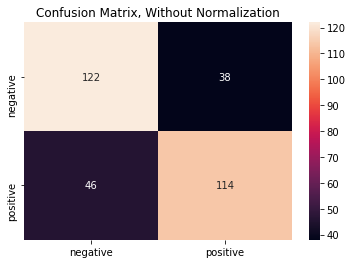

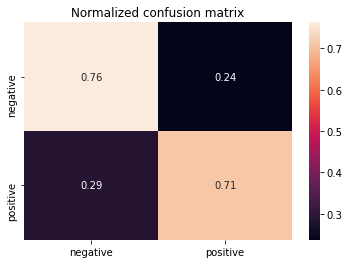

In [19]:
y_pred = gscv.predict(X_test)

#confusion matrix
cm = confusion_matrix(y_test, y_pred)
ax = plt.axes()
sns.heatmap(cm, annot=True, fmt = 'd', xticklabels = target_names, yticklabels = target_names)
ax.set_title("Confusion Matrix, Without Normalization")
plt.show()

#normalized confusion matrix
cm2 = cm / cm.astype(np.float64).sum(axis=1)[:,None]
ax = plt.axes()
sns.heatmap(cm2, annot=True, fmt = '.2f', xticklabels = target_names, yticklabels = target_names)
ax.set_title("Normalized confusion matrix")
plt.show()

In [20]:
print(classification_report(y_test, y_pred, target_names = target_names))

              precision    recall  f1-score   support

    negative       0.73      0.76      0.74       160
    positive       0.75      0.71      0.73       160

    accuracy                           0.74       320
   macro avg       0.74      0.74      0.74       320
weighted avg       0.74      0.74      0.74       320



Reference links

https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html <br>
https://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html <br>
https://stackoverflow.com/questions/2354329/what-is-the-meaning-of-r <br>
https://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html <br>
https://machinelearningmastery.com/tour-of-evaluation-metrics-for-imbalanced-classification/ <br>
https://stackoverflow.com/questions/48507651/multiple-classification-models-in-a-scikit-pipeline-python <br>
https://scikit-learn.org/stable/tutorial/machine_learning_map/index.html <br>
https://scikit-learn.org/stable/modules/generated/sklearn.base.BaseEstimator.html <br>
https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html <br>
https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html <br>
https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html <br>
https://seaborn.pydata.org/generated/seaborn.heatmap.html